<a href="https://colab.research.google.com/github/metalusuraimu/DL_learning/blob/master/lecture5/image_generation_kiyomoto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 復習
https://qiita.com/metarusulaimu/private/87544ffb134939446771

# RNNによる画像生成
画像を時系列のデータと捉えることで、RNNにより画像を生成することが可能になります。  
今回は、画像データを使ってRNNを訓練し、画像の上半分をもとに画像の下半分を生成します。  
RNNの層にはLSTMを使用します。  


## Fashion-MNIST
torchvision.datasetsを使い、Fashion-MNISTを読み込みます。  

Fashion-MNISTは、衣類の画像データセットで
各サンプルは 28×28 グレースケール画像、60,000枚の訓練セットと10,000枚のテストセットです。

＜参考URL＞
https://newtechnologylifestyle.net/keras_fashion-mnist/

以下のコードでは、Fashion-MNISTを読み込み、ランダムな25枚の画像を表示します。

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!
データの数: 60000


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

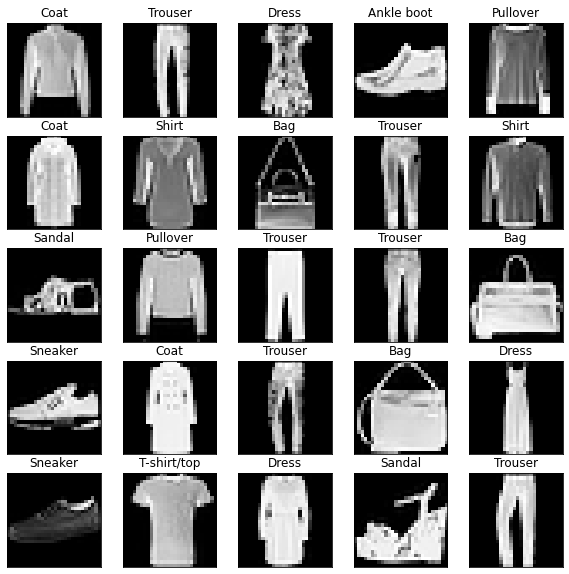

In [1]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

fmnist_data = FashionMNIST(root="./data",
                            train=True,download=True,
                            transform=transforms.ToTensor())
fmnist_classes = np.array(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                            "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"])
print("データの数:", len(fmnist_data))

n_image = 25  # 表示する画像の数
fmnist_loader = DataLoader(dataset=fmnist_data, batch_size=n_image, shuffle=True)
dataiter = iter(fmnist_loader)  # イテレータ（中身のコピー）
print(dataiter)
images, labels = dataiter.next()  # 最初のバッチを取り出す 

img_size = 28
plt.figure(figsize=(10,10))  # 画像の表示サイズ
for i in range(n_image):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i].reshape(img_size, img_size), cmap="Greys_r")
    label = fmnist_classes[labels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に

plt.show()

## データの前処理
画像データをRNNに適した形に整えます。  
画像を時系列データに変換しますが、正解は時系列の次の行にします。 

https://note.nkmk.me/python-numpy-reshape-usage/

In [7]:
import torch
from torch.utils.data import DataLoader

n_time = 14  # 時系列の数（半分の画像なので）
n_in = img_size  # 入力層のニューロン数＝２８
n_mid = 256  # 中間層のニューロン数
n_out = img_size  # 出力層のニューロン数＝２８
n_sample_in_img = img_size - n_time  # 1枚の画像中のサンプル数=14サンプル

dataloader = DataLoader(fmnist_data, batch_size=len(fmnist_data), shuffle=False)
dataiter = iter(dataloader)  # イテレータ
train_imgs, labels = dataiter.next()  # データを取り出す
print(np.ndim(train_imgs))
print(np.shape(train_imgs))
train_imgs = train_imgs.reshape(-1, img_size, img_size)
print(np.ndim(train_imgs))
print(np.shape(train_imgs))

n_sample = len(train_imgs) * n_sample_in_img  # サンプル数

input_data = np.zeros((n_sample, n_time, n_in))  # 入力
correct_data = np.zeros((n_sample, n_out))  # 正解
for i in range(len(train_imgs)):
    for j in range(n_sample_in_img):
        sample_id = i*n_sample_in_img + j
        input_data[sample_id] = train_imgs[i, j:j+n_time]
        correct_data[sample_id] = train_imgs[i, j+n_time]

input_data = torch.tensor(input_data, dtype=torch.float)  # テンソルに変換
correct_data = torch.tensor(correct_data, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(input_data, correct_data)  # データセットの作成

train_loader = DataLoader(dataset, batch_size=128, shuffle=True)  # DataLoaderの設定

4
torch.Size([60000, 1, 28, 28])
3
torch.Size([60000, 28, 28])


## テスト用のデータ
今回は、訓練済みのモデルが機能することを確かめるためにFashionMNISTのテスト用データの取り出しを実施。

In [ ]:
n_disp = 10  # 生成し表示する画像の数

disp_data = FashionMNIST(root="./data",
                            train=False,download=True,
                            transform=transforms.ToTensor())
disp_loader = DataLoader(disp_data, batch_size=n_disp, shuffle=False)
dataiter = iter(disp_loader)  # イテレータ
disp_imgs, labels = dataiter.next()  # データを取り出す
disp_imgs = disp_imgs.reshape(-1, img_size, img_size)

## 画像生成用の関数
以下の関数は、オリジナルの画像`disp_imgs`と、この画像の上半分をもとに下半分を生成した`gen_imgs`を並べて表示します。  
最初は画像の上半分をシードにして新たな行を生成しますが、次はその新たな行を含む直近の時系列からさらに次の行を生成します。  
これを繰り返すことで、下半分の画像が生成されます。  

In [ ]:
def generate_images():
    # オリジナルの画像
    print("Original:")
    plt.figure(figsize=(20, 2))
    for i in range(n_disp):
        ax = plt.subplot(1, n_disp, i+1)
        plt.imshow(disp_imgs[i], cmap="Greys_r", vmin=0.0, vmax=1.0)
        ax.get_xaxis().set_visible(False)  # 軸を非表示に
        ax.get_yaxis().set_visible(False)
    plt.show()

    # 下半分をRNNにより生成した画像
    print("Generated:")
    gen_imgs = disp_imgs.clone() #オリジナルの画像のコピー
    plt.figure(figsize=(20, 2))
    for i in range(n_disp): # 表示する画像数分のループ
        for j in range(n_sample_in_img):
            x = gen_imgs[i, j:j+n_time].reshape(1, n_time, img_size)
            #入力データの整形。３次のテンソルにしてる（pytrochのLSTMの制約？）
            x = x.cuda()  # GPU対応
            gen_imgs[i, j+n_time] = net(x)[0]
        ax = plt.subplot(1, n_disp, i+1)
        plt.imshow(gen_imgs[i].detach(), cmap="Greys_r", vmin=0.0, vmax=1.0)
        ax.get_xaxis().set_visible(False)  # 軸を非表示に
        ax.get_yaxis().set_visible(False)
    plt.show()

## モデルの構築
`nn.Module`モジュールを継承したクラスとして、モデルを構築します。  
LSTMは`nn.LSTM`を使って実装することができます。  
RNN、LSTM、GRUモデルの中身に関しては日本語でざっくりとした説明してある記事がありました。  
https://qiita.com/iBotamon/items/f419567b5da090d2c136

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.GRU(  #LSTM層（sinmleRNNと違う箇所。　nn.GRUにするとGRU）
            input_size=n_in,  # 入力サイズ
            hidden_size=n_mid,  # ニューロン数
            batch_first=True,  # 入力を (バッチサイズ, 時系列の数, 入力の数) にする
        )
        self.fc = nn.Linear(n_mid, n_out)  # 全結合層

    def forward(self, x):
        # y_rnn, (h, c) = self.rnn(x, None)  # hは次の時刻に渡される値、 cは記憶セル
        y_rnn, h = self.rnn(x, None)  # GRUのときはこっち
        y = self.fc(y_rnn[:, -1, :])  # yは最後の時刻の出力
        return y

net = Net()
net.cuda()  # GPU対応
print(net)



# 参考sinmpleRNNのモデル
# import torch.nn as nn
# import torch.nn.functional as F

# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.rnn = nn.RNN(  # RNN層
#             input_size=1,  # 入力サイズ
#             hidden_size=64,  # ニューロン数
#             batch_first=True,  # 入力を (バッチサイズ, 時系列の数, 入力の数) にする
#         )
#         self.fc = nn.Linear(64, 1)  # 全結合層

#     def forward(self, x):
#         y_rnn, h = self.rnn(x, None)  # hは次の時刻に渡される値、 Noneでその初期値が0に
#         y = self.fc(y_rnn[:, -1, :])  # yは最後の時刻の出力
#         return y

# net = Net()
# print(net)

Net(
  (rnn): GRU(28, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=28, bias=True)
)


## 学習
モデルを訓練します。  
DataLoaderを使い、ミニバッチを取り出して訓練および評価を行います。  
学習中、一定のエポック間隔ごとに誤差の表示と画像の生成が行われます。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。  
GRUとLSTMでの計算時間の違いを%%time計測してみた結果が下記になります。なぜか全く同じ時間になりました。。  
LSTM　→  １０エポック　4分58秒  
         3エポック　CPU times: user 1min 29s, sys: 1.95 s, total: 1min 30s  
GRU　→　１０エポック　4分58秒  
　3エポック　CPU times: user 1min 28s, sys: 1.95 s, total: 1min 30s



Epoch: 0 Loss_Train: 0.017366747096201916
Original:


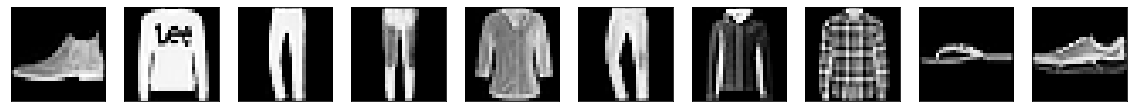

Generated:


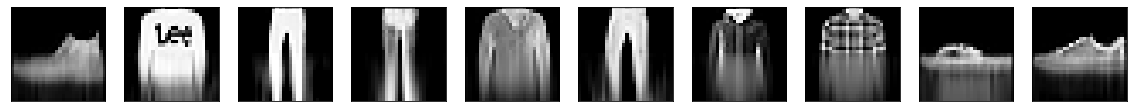

Epoch: 1 Loss_Train: 0.013609629130575868
Original:


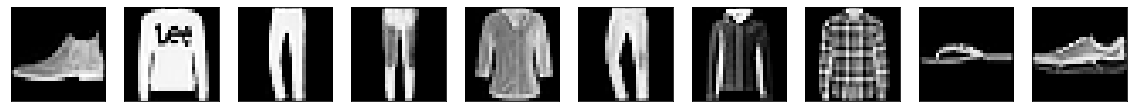

Generated:


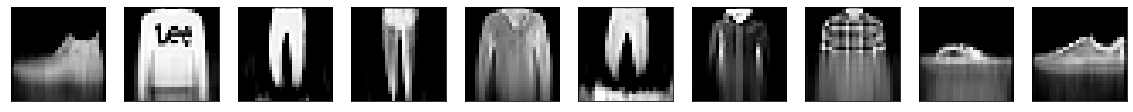

Epoch: 2 Loss_Train: 0.012628504581497984
Original:


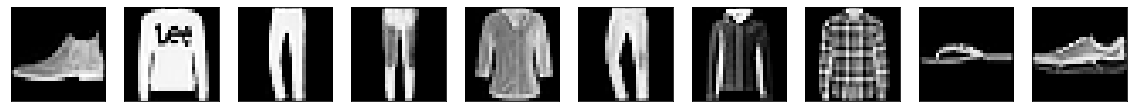

Generated:


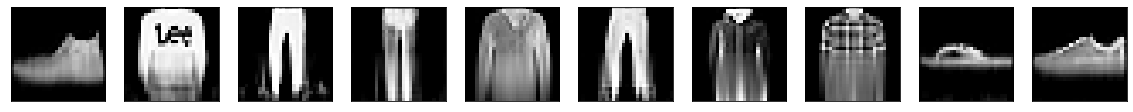

Epoch: 3 Loss_Train: 0.01215392007492057
Original:


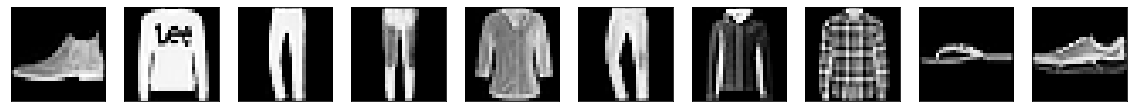

Generated:


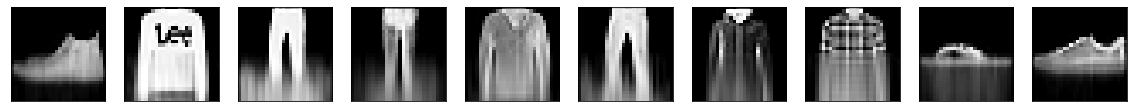

Epoch: 4 Loss_Train: 0.011828465971164263
Original:


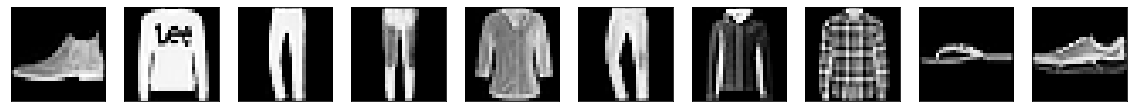

Generated:


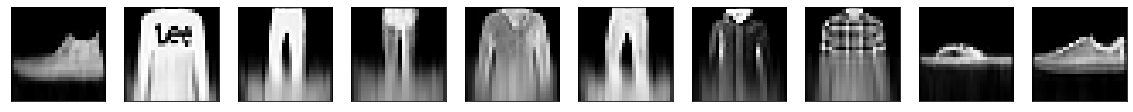

Epoch: 5 Loss_Train: 0.011577482598645147
Original:


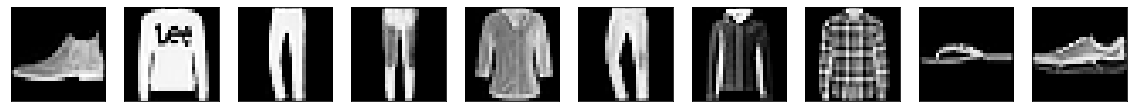

Generated:


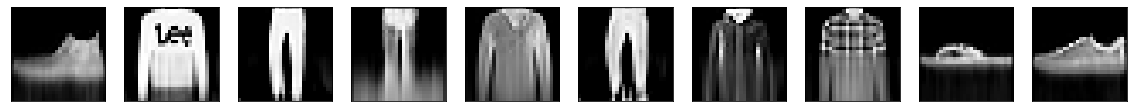

In [ ]:
%%time
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.MSELoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())  # 学習率は0.01 simpleRNNではSGDを利用

# 損失のログ
record_loss_train = []

# 学習
for i in range(25):  # 25エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train)
        generate_images()

## 誤差の推移
誤差の推移をグラフ表示します。  

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

滑らかに誤差が減少していることが確認できます。